# Example to connect to postgres

This is a tutorial to connect to our PostgreSQL database using python.

First you need to install the following libraries:
- psycopg2
- python-dotenv

Then you need to create a file with the name ".env". This file will contain the connection information and your credentials. This is an example:

```
DB_HOST=host_name
DB_NAME=postgres
DB_USER=my_user
DB_PASSWORD=my_password
DB_PORT=5432
```

After that you´re all set. We will import your credentials and connect to the database.

In [64]:
import os
import psycopg2 # PostgreSQL database adapter for Python
from dotenv import load_dotenv # Reads the key-value pair from .env file and adds them to environment variable

# Load environment variables from .env file
load_dotenv()

# Accessing credentials
db_host = os.getenv("DB_HOST")
db_name = os.getenv("DB_NAME")
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_port = os.getenv("DB_PORT")

In [65]:
# Connect to the database
conn = psycopg2.connect(
    host=db_host,
    dbname=db_name,
    user=db_user,
    password=db_password,
    port=db_port
)

Now we can query our data (write sql code) and store it as a pandas dataframe

In [66]:
import pandas as pd
from sklearn.metrics import mean_squared_error

In [130]:
query="""
    select * 
    from agg.t_msb1m  
    where year = 2019 and site=84 and min = 0 and month = 6
"""

In [131]:
df = pd.read_sql_query(query, conn)

C:\Users\xlow6\AppData\Local\Temp\ipykernel_40184\1553155693.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   site              720 non-null    int64  
 1   year              720 non-null    int64  
 2   month             720 non-null    int64  
 3   day               720 non-null    int64  
 4   hour              720 non-null    int64  
 5   min               720 non-null    int64  
 6   tz                720 non-null    object 
 7   soc               720 non-null    float64
 8   discharge_wh      720 non-null    float64
 9   charge_wh         720 non-null    float64
 10  production_wh     720 non-null    float64
 11  consumption_wh    720 non-null    float64
 12  gridexport_wh     720 non-null    float64
 13  gridimport_wh     720 non-null    float64
 14  pvcharge_wh       720 non-null    float64
 15  pvcons_wh         720 non-null    float64
 16  pvexport_wh       720 non-null    float64
 1

In [133]:
df = df.rename(columns={'min': 'minute'})
df['datetime'] = pd.to_datetime(df[['year','month', 'day', 'hour','minute']])
df['net_load'] = df['consumption_wh'] + df['charge_wh'] - df['discharge_wh'] - df['production_wh']


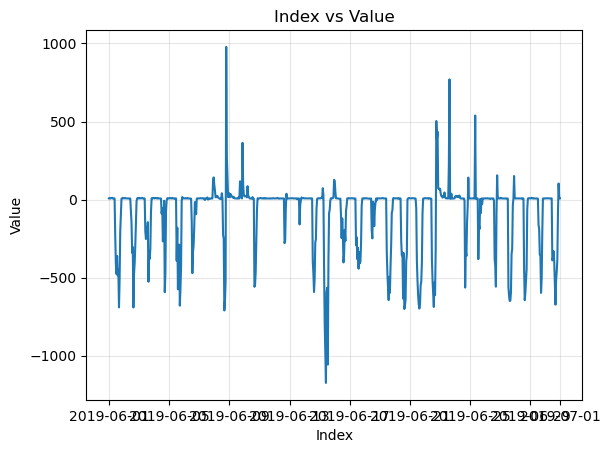

In [134]:
import matplotlib.pyplot as plt

plt.plot(df['datetime'],df['net_load'])
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Index vs Value')
plt.grid(alpha=0.3) 
plt.show()

(array([18048., 18052., 18056., 18060., 18064., 18068., 18072., 18076.,
        18078.]),
 [Text(18048.0, 0, '2019-06-01'),
  Text(18052.0, 0, '2019-06-05'),
  Text(18056.0, 0, '2019-06-09'),
  Text(18060.0, 0, '2019-06-13'),
  Text(18064.0, 0, '2019-06-17'),
  Text(18068.0, 0, '2019-06-21'),
  Text(18072.0, 0, '2019-06-25'),
  Text(18076.0, 0, '2019-06-29'),
  Text(18078.0, 0, '2019-07-01')])

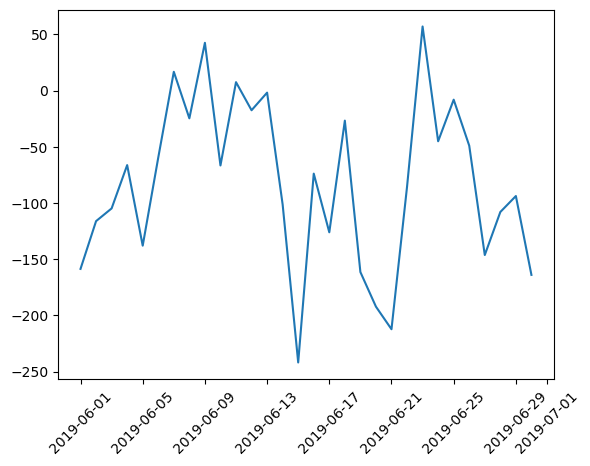

In [135]:
avg_load_day = df.groupby(df['datetime'].dt.date)['net_load'].mean()

plt.plot(avg_load_day)

plt.xticks(rotation=45) 

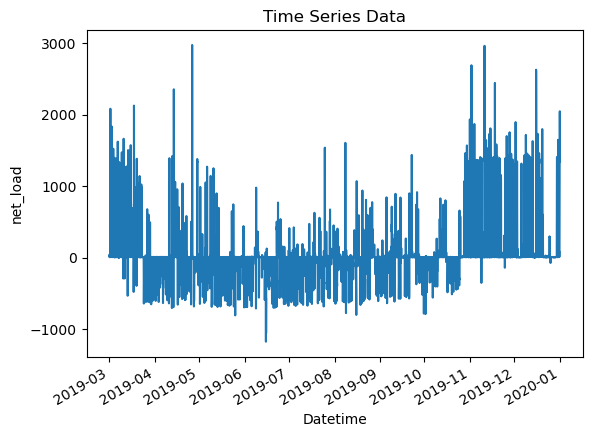

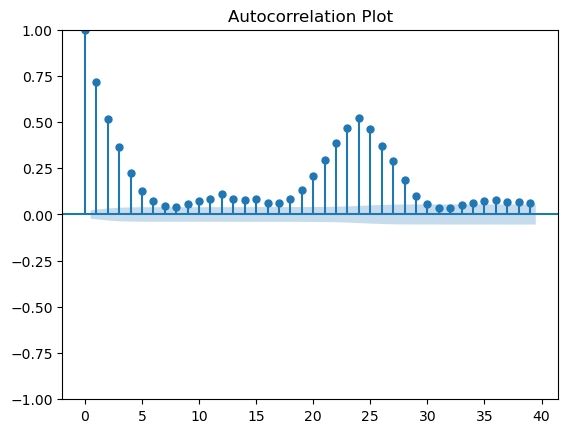

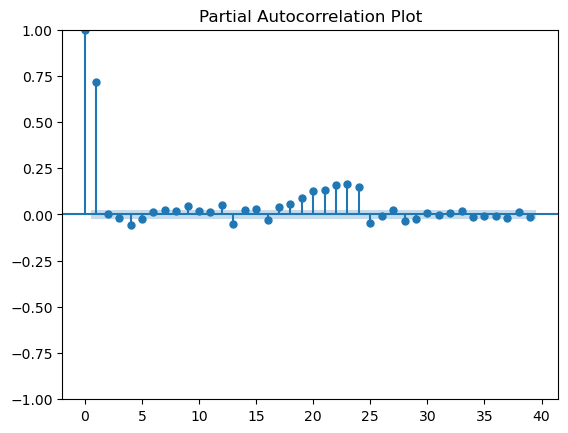

c:\Users\xlow6\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\xlow6\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\xlow6\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               net_load   No. Observations:                 7336
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -50577.615
Date:                Mon, 25 Mar 2024   AIC                         101161.229
Time:                        15:33:19   BIC                         101181.931
Sample:                             0   HQIC                        101168.346
                               - 7336                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6696      0.005    138.061      0.000       0.660       0.679
ma.L1         -0.9929      0.001   -680.697      0.000      -0.996      -0.990
sigma2       5.71e+04    307.931    185.423      0.0

c:\Users\xlow6\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\xlow6\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


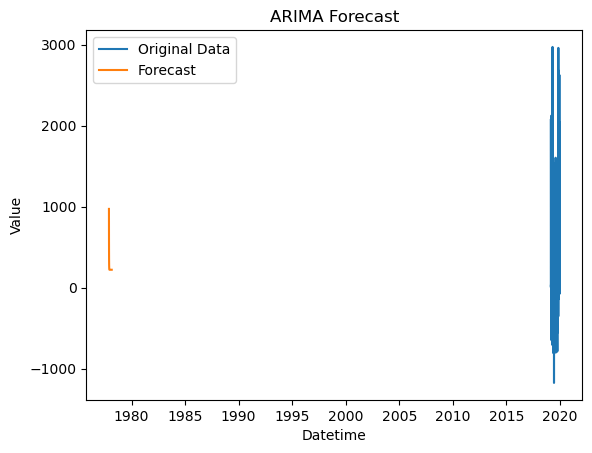

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming 'df' is your DataFrame with datetime index and 'value' column

# Plot the time series data
df['net_load'].plot()
plt.xlabel('Datetime')
plt.ylabel('net_load')
plt.title('Time Series Data')
plt.show()

# Plot autocorrelation and partial autocorrelation plots
plot_acf(df['net_load'])
plt.title('Autocorrelation Plot')
plt.show()

plot_pacf(df['net_load'])
plt.title('Partial Autocorrelation Plot')
plt.show()

# Fit ARIMA model
order = (1, 1, 1)  # Example: ARIMA(2,1,1) model
model = ARIMA(df['net_load'], order=order)
fitted_model = model.fit()

# Summary of the model
print(fitted_model.summary())

# Forecast future values for the next day (96 15-minute intervals)
forecast_steps = 96
forecast = fitted_model.forecast(steps=forecast_steps)

# Generate datetime index for the forecasted values
last_datetime = df.index[-1]
#forecast_index = pd.date_range(start=last_datetime, periods=forecast_steps + 1, freq='15T')[1:]  # Start from the next interval
forecast_index = list(range(2879, 2975))

# Plot the original data and forecasted values
plt.plot(df.index, df['net_load'], label='Original Data')
plt.plot(forecast_index, forecast, label='Forecast')
plt.xlabel('Datetime')
plt.ylabel('Value')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()


c:\Users\xlow6\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Mean Squared Error: 21441.99509414791
Forecasted Values: 696      6.211829
697      3.584229
698      2.387302
699      1.830274
700      2.072181
701      7.347875
702      1.982504
703    -10.934675
704     -7.708655
705    -31.194012
706    -75.356179
707   -113.216660
708   -148.575664
709   -243.565046
710   -262.858276
711   -289.919225
712   -354.998211
713   -357.628260
714   -232.268896
715    -64.036024
716      9.608100
717     23.056009
718     14.664045
719     12.357785
Name: predicted_mean, dtype: float64


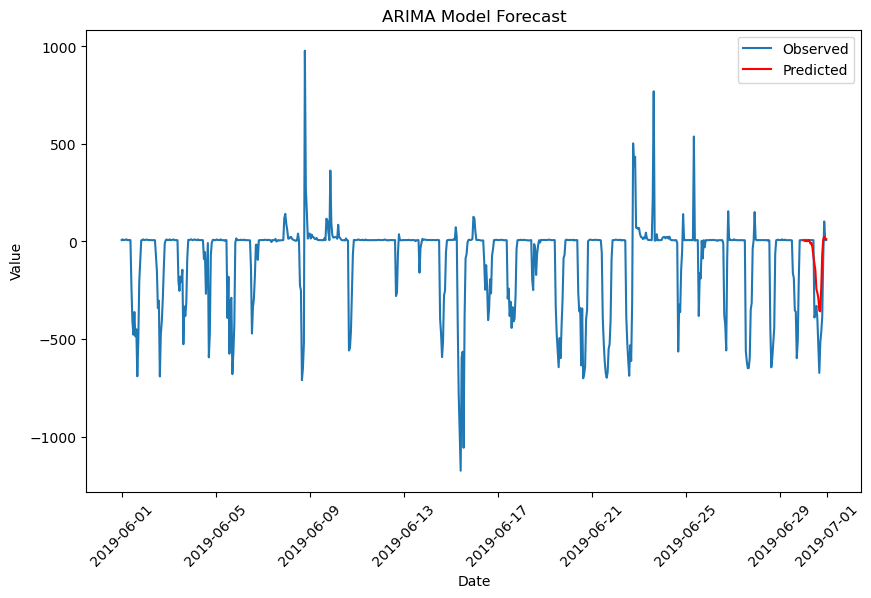

In [42]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

train_data = df.iloc[:-24]  
test_data = df.iloc[-24:]

# Step 6: SARIMA Modeling
# Fit ARIMA model to the training data
model = SARIMAX(train_data['net_load'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))  # Example order, adjust as needed
arima_model = model.fit()

# Step 7: Model Evaluation
# Make predictions on the testing set
predictions = arima_model.predict(start=len(train_data), end=len(train_data)+len(test_data)-1, typ='levels')
mse = mean_squared_error(test_data['net_load'], predictions)
print('Mean Squared Error:', mse)

# Step 8: Forecasting
# Use the trained ARIMA model to forecast future time periods
forecast_horizon = 24
forecast = arima_model.forecast(steps=forecast_horizon)
print('Forecasted Values:', forecast)

plt.figure(figsize=(10, 6))
plt.plot(df['datetime'], df['net_load'], label='Observed')
plt.plot(test_data['datetime'], predictions, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('ARIMA Model Forecast')
plt.legend()
plt.xticks(rotation=45) 
plt.show()

480   2019-06-21 00:00:00
481   2019-06-21 01:00:00
482   2019-06-21 02:00:00
483   2019-06-21 03:00:00
484   2019-06-21 04:00:00
485   2019-06-21 05:00:00
486   2019-06-21 06:00:00
487   2019-06-21 07:00:00
488   2019-06-21 08:00:00
489   2019-06-21 09:00:00
490   2019-06-21 10:00:00
491   2019-06-21 11:00:00
492   2019-06-21 12:00:00
493   2019-06-21 13:00:00
494   2019-06-21 14:00:00
495   2019-06-21 15:00:00
496   2019-06-21 16:00:00
497   2019-06-21 17:00:00
498   2019-06-21 18:00:00
499   2019-06-21 19:00:00
500   2019-06-21 20:00:00
501   2019-06-21 21:00:00
502   2019-06-21 22:00:00
503   2019-06-21 23:00:00
Name: datetime, dtype: datetime64[ns]
Forecasted Values: 480      2.421356
481     -3.981081
482     -7.749797
483     -9.288204
484     -9.898856
485     -3.529167
486    -10.778703
487    -32.156342
488    -50.247327
489    -59.814663
490   -138.576159
491   -166.251058
492   -205.206014
493   -282.530414
494   -278.083611
495   -314.311808
496   -352.825698
497   -340.99

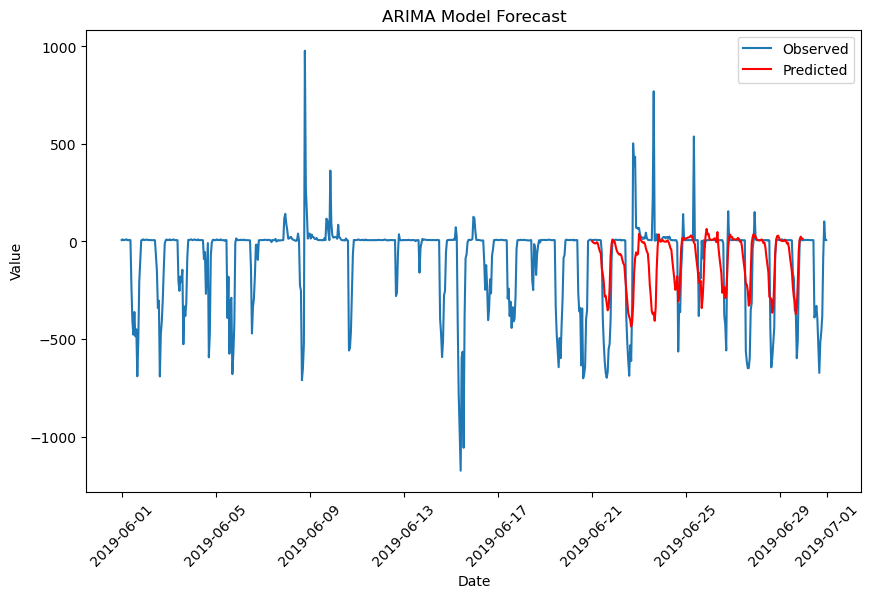

In [154]:
results= pd.DataFrame()
for x in range(10, 0, -1):
    break_val = -24*x
    break_val2 = -24*(x-1)
    train = df.iloc[:break_val]
    test = df.iloc[break_val:break_val2]

    model = SARIMAX(train['net_load'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))  # Example order, adjust as needed
    arima_model = model.fit()


    #predictions = arima_model.predict(start=len(train), end=len(train)+len(test)-1, typ='levels')
    #mse = mean_squared_error(test['net_load'], predictions)
    #print('Mean Squared Error:', mse)
    print(test['datetime'])
    forecast_horizon = 24
    forecast = arima_model.forecast(steps=forecast_horizon)
    print('Forecasted Values:', forecast)
    forecast_df = pd.DataFrame({'forecast': forecast}, index=test.index)

    # Merge forecast_df with test DataFrame on index
    test_with_forecast = pd.merge(test, forecast_df, left_index=True, right_index=True)

    # Concatenate test_with_forecast with results
    results = pd.concat([results, test_with_forecast], ignore_index=True)



plt.figure(figsize=(10, 6))
plt.plot(df['datetime'], df['net_load'], label='Observed')
plt.plot(results['datetime'],results['forecast'], label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('ARIMA Model Forecast')
plt.legend()
plt.xticks(rotation=45) 
plt.show()

In [146]:
print(con_df)

      forecast datetime
696  11.508519      NaT
697   7.432244      NaT
698  10.300748      NaT
699   8.079322      NaT
700   9.819654      NaT
701   8.481950      NaT
702   9.510317      NaT
703   8.727094      NaT
704   9.325080      NaT
705   8.877267      NaT
706   9.213750      NaT
707   8.969717      NaT
708   9.147410      NaT
709   9.027119      NaT
710   9.108381      NaT
711   9.063236      NaT
712   9.085940      NaT
713   9.086427      NaT
714   9.073570      NaT
715   9.101770      NaT
716   9.067317      NaT
717   9.112346      NaT
718   9.064779      NaT
719   9.120027      NaT


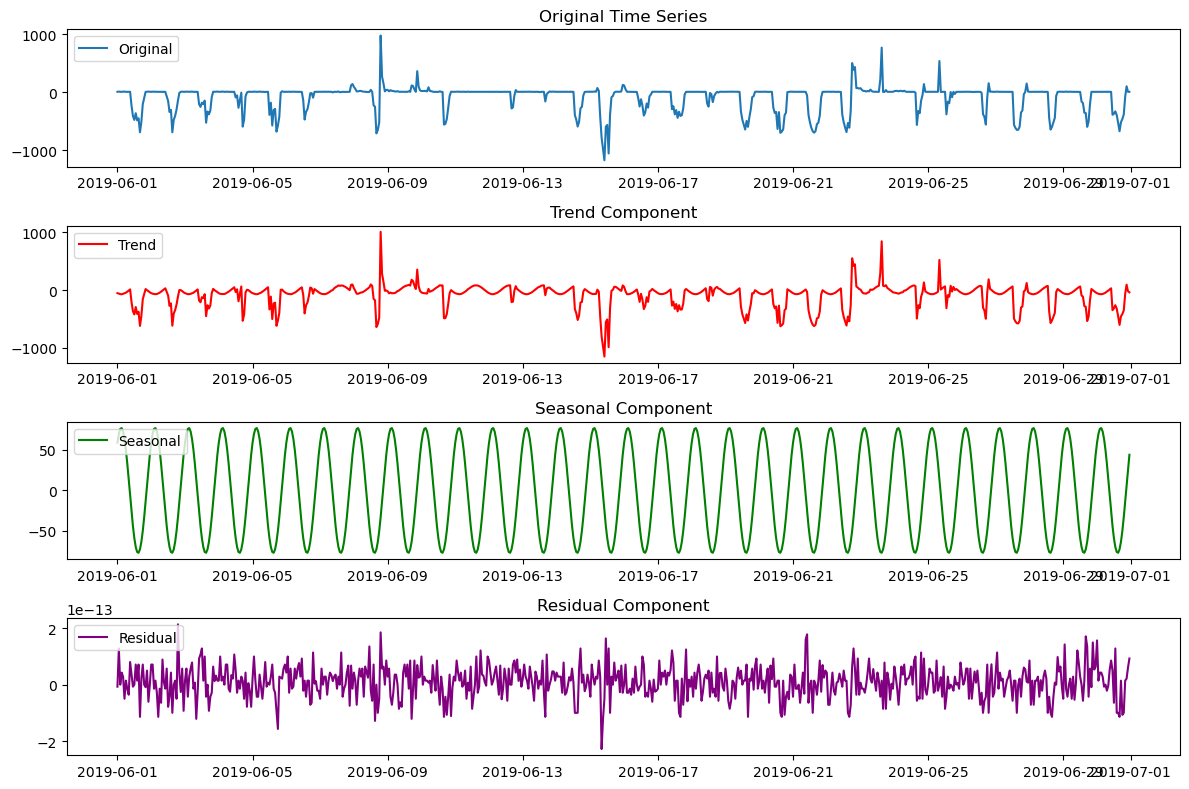

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#df.set_index('datetime', inplace=True)

# Function to decompose time series using Fourier transform
def decompose_fourier(data):
    
    # Compute FFT of the time series data
    fft_values = np.fft.fft(data)
    
    # Compute the frequencies corresponding to the FFT values
    frequencies = np.fft.fftfreq(len(data))
    
    # Find the index of the highest amplitude frequency (excluding the DC component)
    highest_freq_index = np.argmax(np.abs(fft_values[1:])) + 1
    
    # Construct the signal corresponding to the highest amplitude frequency
    reconstructed_signal = np.fft.ifft(np.zeros_like(fft_values))
    reconstructed_signal[highest_freq_index] = fft_values[highest_freq_index]
    
    # Compute the trend component by removing the highest amplitude frequency from the original signal
    trend_component = np.fft.ifft(fft_values - reconstructed_signal)
    
    # Compute the seasonal component by keeping only the highest amplitude frequency
    seasonal_component = np.fft.ifft(reconstructed_signal)
    
    # Compute the residual component by subtracting the trend and seasonal components from the original signal
    residual_component = data - trend_component - seasonal_component
    
    return trend_component, seasonal_component, residual_component

# Decompose the time series data using Fourier transform
trend, seasonal, residual = decompose_fourier(df['net_load'])

# Plot the decomposed components
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(df.index, df['net_load'], label='Original')
plt.legend(loc='upper left')
plt.title('Original Time Series')

plt.subplot(412)
plt.plot(df.index, trend, label='Trend', color='red')
plt.legend(loc='upper left')
plt.title('Trend Component')

plt.subplot(413)
plt.plot(df.index, seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')
plt.title('Seasonal Component')

plt.subplot(414)
plt.plot(df.index, residual, label='Residual', color='purple')
plt.legend(loc='upper left')
plt.title('Residual Component')

plt.tight_layout()
plt.show()


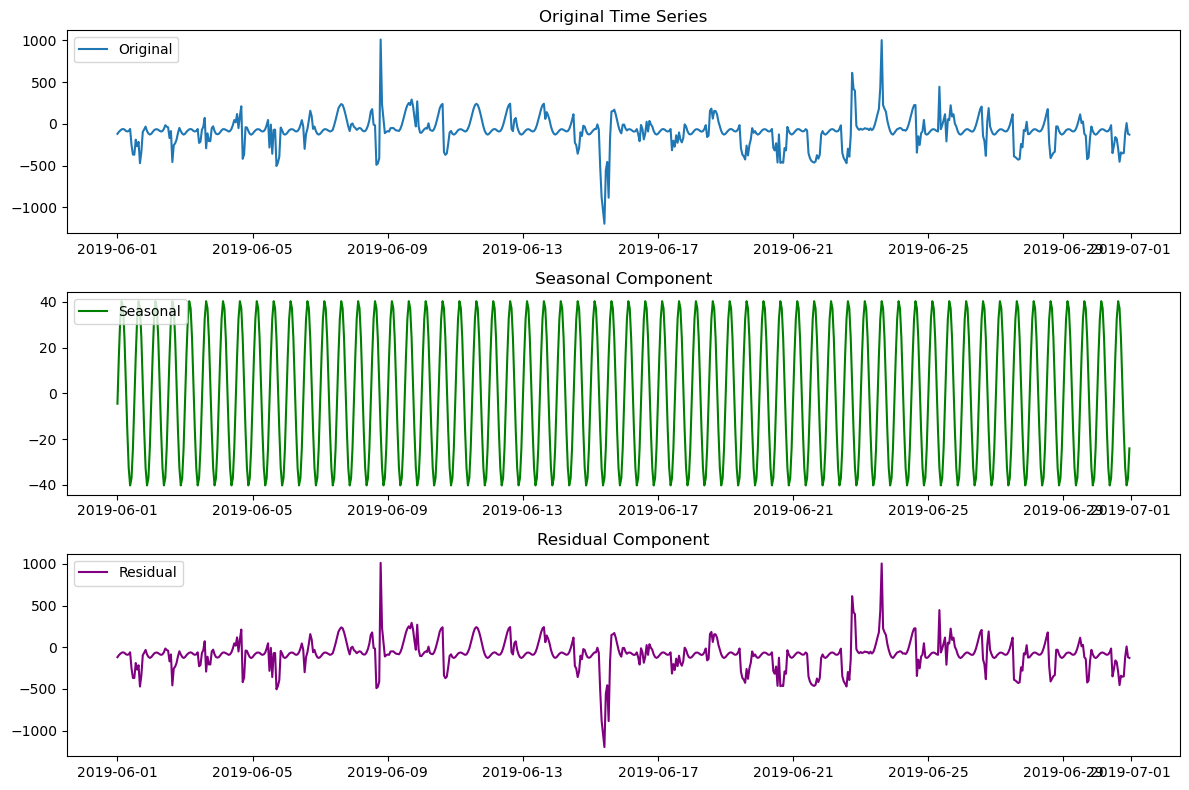

720


In [84]:
def decompose_fourier_multiple(data, seasonal_periods):
    # Compute FFT of the time series data
    fft_values = np.fft.fft(data)
    
    # Compute the frequencies corresponding to the FFT values
    frequencies = np.fft.fftfreq(len(data))
    
    # Initialize reconstructed signal as zeros
    reconstructed_signal = np.zeros_like(fft_values)
    
    # Iterate over seasonal periods
    for period in seasonal_periods:
        # Find the index of the highest amplitude frequency for the current period (excluding the DC component)
        highest_freq_index = np.argmax(np.abs(fft_values[1:])) + 1
        
        # Construct the signal corresponding to the highest amplitude frequency
        reconstructed_signal[highest_freq_index] = fft_values[highest_freq_index]
        
        # Compute the seasonal component by keeping only the highest amplitude frequency for the current period
        seasonal_component = np.fft.ifft(reconstructed_signal)
        
        # Subtract the seasonal component from the original signal
        data -= seasonal_component
        
        # Reset the reconstructed signal for the next seasonal component
        reconstructed_signal = np.zeros_like(fft_values)
    
    # Compute the residual component (what remains after removing all seasonal components)
    residual_component = data
    
    return seasonal_component, residual_component

# Decompose the time series data using Fourier transform with multiple seasonal components
seasonal, residual = decompose_fourier_multiple(df['net_load'], seasonal_periods=[24])  # Example seasonal periods

# Plot the decomposed components
plt.figure(figsize=(12, 8))

plt.subplot(311)
plt.plot(df.index, df['net_load'], label='Original')
plt.legend(loc='upper left')
plt.title('Original Time Series')

plt.subplot(312)
plt.plot(df.index, seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')
plt.title('Seasonal Component')

plt.subplot(313)
plt.plot(df.index, residual, label='Residual', color='purple')
plt.legend(loc='upper left')
plt.title('Residual Component')

plt.tight_layout()
plt.show()
print(len(seasonal))

c:\Users\xlow6\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


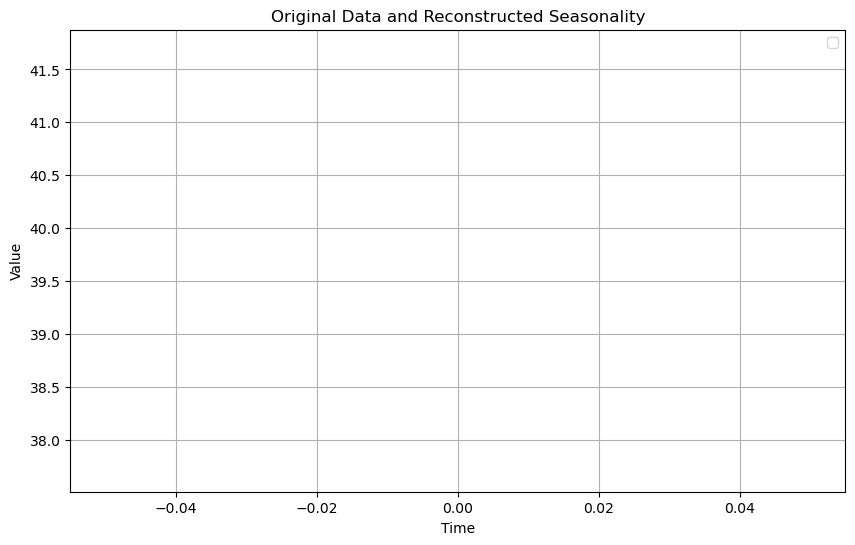

In [106]:
from scipy.optimize import curve_fit

T_d = 24  # Period of one day (in hours)
T_y = 365 * 24  # Period of one year (in hours)

def fourier_series(t, a0, *params):
    N = len(params) // 6  # Number of harmonics
    an = params[:N]
    bn = params[N:2*N]
    cm = params[2*N:3*N]
    dm = params[3*N:]
    series_day = sum(a * np.cos(2 * np.pi * n * t / T_d) + b * np.sin(2 * np.pi * n * t / T_d) for n, (a, b) in enumerate(zip(an, bn), start=1))
    series_year = sum(c * np.cos(2 * np.pi * m * t / T_y) + d * np.sin(2 * np.pi * m * t / T_y) for m, (c, d) in enumerate(zip(cm, dm), start=1))
    print(series_day)
    print(series_year)
    return a0 + series_day + series_year

# Initial guess for parameters
initial_guess = [np.mean(df['net_load'])] + [0] * 4

# Fit Fourier series to data
params, _ = curve_fit(fourier_series, np.arange(len(df)), df['net_load'], p0=initial_guess)

# Reconstruct seasonality
seasonality = fourier_series(np.arange(len(df)), params[0],params)

# Plot original data and reconstructed seasonality
plt.figure(figsize=(10, 6))
#plt.plot(df.index, df['net_load'], label='Observed Data', color='blue')
plt.plot(seasonality)
#plt.plot(df.index, seasonality, label='Seasonality', color='red')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Original Data and Reconstructed Seasonality')
plt.legend()
plt.grid(True)
plt.show()